<img src="attachment:images/odd_block.png" height="200">

# Using parameterized circuits to approximate a quantum state

### David Radcliffe, 11 Sept 2020

In this notebook, we construct a parameterized quantum circuit with several layers, and we train the parameters in order to approximate a random quantum state. This is part of my application to enroll in the QC Mentorship Program of the Quantum Open Source Foundation.

### Problem statement

Suppose that we construct a quantum circuit on 4 qubits in the following manner. 

* The circuit consists of $L$ layers.
* Each layer consists of an *odd block* followed by an *even block*.
* An *odd block* applies an $R_x$ gate to each qubit, as shown in Figure 1.
* An *even block* applies an $R_z$ gate to each qubit, and then applies a CZ gate to each pair of qubits, as shown in Figure 2.
* Each $R_x$ or $R_z$ gate has an independent parameter $\theta_{i,j}$. There are $8L$ such parameters, and we view them as components of a vector $\Theta$.
* The quantum register is initialized to the zero state.

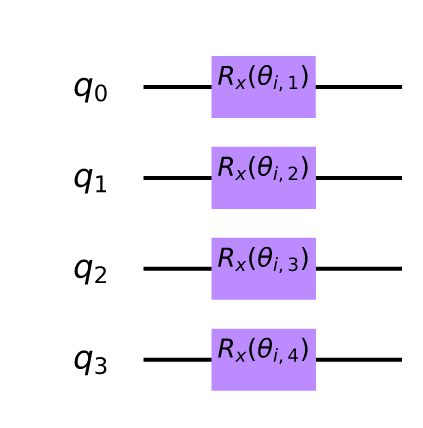

In [1]:
from IPython.display import Image
Image('odd_block.png', width=300)

**Figure 1.** An odd block.

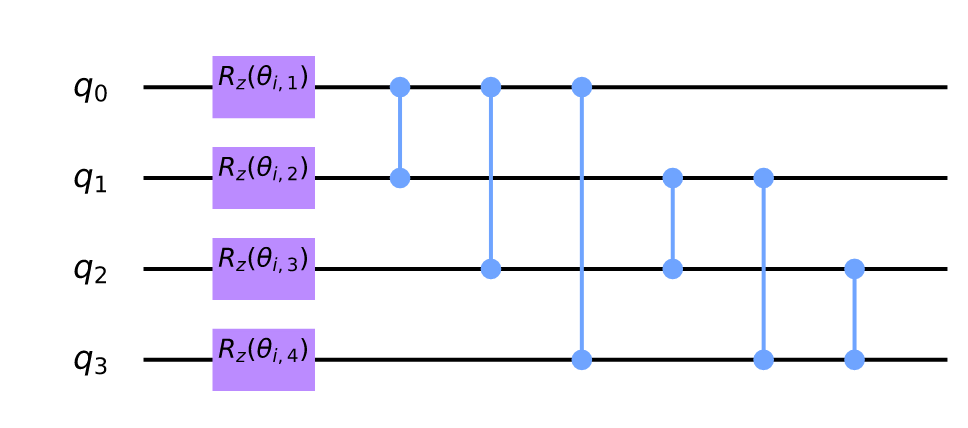

In [2]:
from IPython.display import Image
Image('even_block.png', width=600)

**Figure 2.** An even block.

Let $\vert\psi(0)\rangle$ denote the statevector that is produced by this circuit.

Report with a plot, as a function of the number of layers, $L$, the minimum squared distance

$$\varepsilon(L) = \min_{\Theta} \left\Vert\ \vert\psi(0)\rangle - \vert\phi\rangle\ \right\Vert^2$$

where $\vert\phi\rangle$ is a randomly generated vector on 4 qubits, and 
$$\left\Vert\ \vert v\rangle\ \right\Vert^2 = \langle v \mid v \rangle = \sum_i v_i^\ast v_i.$$

### Solution

We will use Qiskit, an open-source package developed by IBM for quantum computation and quantum simulation. We begin by importing some needed functions and classes.

In [3]:
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, execute, Aer
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import random_statevector

We define a class named `MyCircuit` in order to construct and optimize our circuit.

In [11]:
class MyCircuit:
    def __init__(self, num_qubits=4, **optimizer_options):
        self.num_qubits = num_qubits
        self.circuit = QuantumCircuit(num_qubits)
        self.target = random_statevector(2 ** num_qubits).data
        self.optimizer = COBYLA(**optimizer_options)
        self.num_layers = 0
        self.params = []
        self.minimum_cost = None
        self.initial_point = None
        self.best_params = None

    def add_layers(self, num_layers):
        """Add multiple layers to the circuit."""
        for _ in range(num_layers):
            self.add_layer()
        return self

    def add_layer(self):
        """Add a single layer to the circuit."""
        n = self.num_layers
        self.add_odd_block(2 * n + 1)
        self.add_even_block(2 * n + 2)
        self.num_layers = n + 1
        self.initial_point = None
        return self

    def add_odd_block(self, i):
        """Adds an odd block to the circuit. This is the first half of a layer."""
        params = ParameterVector(f'theta{i}', self.num_qubits)
        self.params.extend(params)
        for j in range(self.num_qubits):
            self.circuit.rx(params[j], j)

    def add_even_block(self, i):
        """Adds an even block to the circuit. This is the second half of a layer."""
        params = ParameterVector(f'theta{i}', self.num_qubits)
        self.params.extend(params)
        for j in range(self.num_qubits):
            self.circuit.rz(params[j], j)
        for j, k in combinations(range(self.num_qubits), 2):
            self.circuit.cz(j, k)

    def run(self, theta):
        """Assigns parameter values, runs the circuit, and returns the statevector."""
        qc = self.circuit.assign_parameters(dict(zip(self.params, theta)))
        result = execute(qc, Aer.get_backend('statevector_simulator')).result()
        statevector = result.get_statevector()
        return statevector
    
    def cost_function(self):
        """Computes the squared distance between the output and target states."""
        return lambda theta: np.linalg.norm(self.run(theta) - self.target) ** 2
     
    def optimize(self):
        """Minimizes the cost function."""
        if self.initial_point is None:
            self.initial_point = 2 * np.pi * np.random.rand(2 * self.num_qubits * self.num_layers)
        vector, value, fn_evals = self.optimizer.optimize(
            len(self.params),
            self.cost_function(),
            initial_point=self.initial_point)
        self.initial_point = vector
        if self.minimum_cost is None or value < self.minimum_cost:
            self.minimum_cost = value
            self.best_params = vector
        return value

When initialized, the class contains a 4-qubit circuit with no layers, as well as a target state on 4 qubits.

The `add_layers` method adds a specified number of variational layers (odd + even blocks) to the circuit.

The `add_layer` method adds a single variational layer to the circuit. This allows us to see how the minimum distance changes with each additional layer.

The `run` method binds a vector of parameter values to the parameters of the circuit, and executes the circuit to yield a statevector.

The `optimize` function estimates the minimum squared distance between the target vector and the output state, over all parameter values.



In [5]:
np.random.seed(2020)
qc = MyCircuit(maxiter=5000)
xs = list(range(1, 7))
ys = [qc.add_layer().optimize() for _ in xs] 

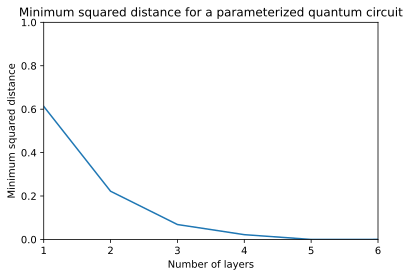

In [6]:
fig, ax = plt.subplots()
plt.plot(xs, ys)
ax.set_xlim(1, len(xs))
ax.set_ylim(0, 1)
ax.set_xlabel('Number of layers')
ax.set_ylabel('Minimum squared distance')
ax.set_title('Minimum squared distance for a parameterized quantum circuit')
plt.show()

In [8]:
df = pd.DataFrame({'layers': xs, 'min_sq_dist': ys}).set_index('layers')
df

,min_sq_dist
layers,
1,0.612898
2,0.222030
3,0.068686
4,0.022037
5,0.000024
6,0.000299


### Discussion

A statevector for $n$ qubits has $2^n$ components, and so it may be impractical to prepare a particular state $\vert \phi\rangle$ when the number of qubits is large. The purpose of this task is to find an approximation for $\vert \phi\rangle$ that can be prepared using a smaller number of gates.
Of course, when $n = 4$, this scheme does not lead to a reduction in the number of gates.